# Logistic Regression from Scratch using NumPy

This notebook provides a complete implementation of the **Logistic Regression** classification algorithm, including key components like the Sigmoid activation function, Binary Cross-Entropy loss, and Gradient Descent, all built using **NumPy** for optimized computation.

The model is trained using Mini-Batch Gradient Descent and evaluated on separate Validation and Test sets.

## 1. Setup and Configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import warnings
warnings.filterwarnings("ignore") # Ignore potential RuntimeWarning related to np.log(0)

# --- Configuration ---
DATA_FILE = 'data/dataset.csv'
TEST_SIZE = 0.20  # 20% for final test set
VAL_SIZE = 0.10   # 10% for validation set
RANDOM_SEED = 42

/Users/doruk/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2. Data Loading and Preprocessing

The dataset is loaded and split into Train (70%), Validation (10%), and Test (20%) sets. A simple Min-Max scaling is applied for feature normalization.

In [5]:
def load_and_split_data(file_path):
    """Loads data, handles initial cleaning, and performs the 70/10/20 split."""
    try:
        # Load data, assuming no header (header=None) and first row/column are not data (skip initial 1:)
        input_data = pd.read_csv(file_path, sep=',', header=None)
        data = input_data.iloc[1:].apply(pd.to_numeric)
        
        X_full = data.values[:, :-1] # All features
        y_full = data.values[:, -1].astype(int) # Target variable
        
        # 1. Split out Test set (20%)
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_full, y_full, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_full
        )
        
        # Recalculate validation size relative to the remaining data (10% of total / 80% remaining = 12.5%)
        val_size_relative = VAL_SIZE / (1.0 - TEST_SIZE)
        
        # 2. Split Temp into Train (70%) and Validation (10%)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_relative, random_state=RANDOM_SEED, stratify=y_temp
        )
        
        print(f"Data loaded. Total samples: {len(data)}")
        print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")
        
        return X_train, y_train, X_val, y_val, X_test, y_test
    
    except FileNotFoundError:
        print(f"ERROR: Data file not found at {DATA_FILE}.")
        print("Please ensure you have created the `data/` directory and placed `dataset.csv` inside.")
        import sys; sys.exit()
        
X_train, y_train, X_val, y_val, X_test, y_test = load_and_split_data(DATA_FILE)

# --- Normalization Parameters ---
# Parameters are calculated ONLY from the training data to prevent data leakage
min_val = X_train.min(axis=0)
max_val = X_train.max(axis=0)
range_val = max_val - min_val

def normalize(X):
    """Applies Min-Max normalization based on training set parameters."""
    return (X - min_val) / (range_val + 1e-8) # Added epsilon for stability

X_train_norm = normalize(X_train)
X_val_norm = normalize(X_val)
X_test_norm = normalize(X_test)

Data loaded. Total samples: 60000
Train: 42000, Validation: 6000, Test: 12000


## 3. Logistic Regression Class Implementation

A class-based implementation for better structure and reusability.

In [ ]:
class CustomLogisticRegression:
    
    def __init__(self, n_features):
        # Initialize weights (w) and bias (b). w will be of shape (n_features, 1).
        self.n_features = n_features
        self.w = np.zeros((n_features, 1))
        self.b = 0.0
        self.losses = []

    def _sigmoid(self, z):
        """The sigmoid activation function."""
        return 1.0 / (1 + np.exp(-z))

    def _binary_cross_entropy_loss(self, y_true, y_pred_proba):
        """Calculates the average Binary Cross-Entropy Loss."""
        m = len(y_true) # Number of samples in the batch/dataset
        # Reshape y_true to match y_pred_proba for element-wise operations
        y_true = y_true.reshape(-1, 1)
        
        # Clip predictions to prevent log(0) which causes RuntimeWarning/NaN
        y_pred_proba = np.clip(y_pred_proba, 1e-15, 1 - 1e-15)
        
        # J = -1/m * sum( y * log(h) + (1-y) * log(1-h) )
        loss_val = (-1/m) * np.sum(y_true * np.log(y_pred_proba) + (1 - y_true) * np.log(1 - y_pred_proba))
        return loss_val
    
    def _initialize_weights(self, weight_init_type):
        """Initializes weights based on the specified type (0: Normal, 1: Uniform, default: Zeros)."""
        np.random.seed(RANDOM_SEED) # Ensure reproducibility
        
        if weight_init_type == 0:
            self.w = np.random.normal(0, 1, (self.n_features, 1))
            self.b = np.random.normal(0, 1)
        elif weight_init_type == 1:
            # Using a simple 1/n initialization
            init_val = 1 / (self.n_features + 1)
            self.w = np.full((self.n_features, 1), init_val)
            self.b = init_val
        else: # Default: Zeros
            self.w = np.zeros((self.n_features, 1))
            self.b = 0.0
            
    def train(self, X, y, batch_size, epochs, learning_rate, weight_init_type=0):
        """Trains the model using Mini-Batch Gradient Descent."""
        m = X.shape[0] # Number of training examples
        self._initialize_weights(weight_init_type)
        y_reshaped = y.reshape(-1, 1)
        
        for epoch in range(epochs):
            # Create mini-batches
            for i in range(0, m, batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y_reshaped[i:i + batch_size]
                m_batch = X_batch.shape[0]
                
                # 1. Forward Pass: Calculate hypothesis (h)
                z = np.dot(X_batch, self.w) + self.b
                h = self._sigmoid(z)
                
                # 2. Backpropagation: Calculate gradients (dw, db)
                error = h - y_batch
                
                dw = (1/m_batch) * np.dot(X_batch.T, error)
                db = (1/m_batch) * np.sum(error)
                
                # 3. Update parameters
                self.w -= learning_rate * dw
                self.b -= learning_rate * db
            
            # Calculate and store loss over the entire training set
            z_full = np.dot(X, self.w) + self.b
            h_full = self._sigmoid(z_full)
            current_loss = self._binary_cross_entropy_loss(y, h_full)
            self.losses.append(current_loss)
            
            # Optional: Print loss every N epochs
            # if (epoch + 1) % 10 == 0: print(f"Epoch {epoch+1}/{epochs} Loss: {current_loss:.4f}")
            
        return self.w, self.b, self.losses

    def predict_proba(self, X):
        """Calculates the probability P(y=1 | X)."""
        z = np.dot(X, self.w) + self.b
        return self._sigmoid(z)
    
    def predict(self, X):
        """Returns class predictions (0 or 1)."""
        probabilities = self.predict_proba(X)
        # Threshold at 0.5
        predictions = (probabilities >= 0.5).astype(int)
        return predictions.flatten()
    
    def evaluate(self, y_true, y_pred):
        """Calculates accuracy and confusion matrix."""
        accuracy = np.sum(y_pred == y_true) / len(y_true) * 100
        
        # Simplified confusion matrix calculation (using sklearn for validation)
        # Format: [[TN, FP], [FN, TP]]
        cm = sk_confusion_matrix(y_true, y_pred, labels=[0, 1])
        
        # Map to the format used in the original code: [[TP, FP], [FN, TN]]
        TP, FN = cm[1, 1], cm[1, 0]
        FP, TN = cm[0, 1], cm[0, 0]
        
        # Returning the custom format: [[TP, FP], [FN, TN]]
        custom_cm = np.array([ [TP, FP], [FN, TN] ])
        
        return accuracy, custom_cm

## 4. Model Training and Evaluation

In [8]:
# Determine the number of features
N_FEATURES = X_train_norm.shape[1]

print(f"Number of Features: {N_FEATURES}\n")

# --- Experiment 1: Full Batch Gradient Descent ---
model_full = CustomLogisticRegression(N_FEATURES)
w_full, b_full, losses_full = model_full.train(
    X=X_train_norm, 
    y=y_train, 
    batch_size=len(X_train_norm), 
    epochs=100, 
    learning_rate=1.0, 
    weight_init_type=0
)

y_pred_val_full = model_full.predict(X_val_norm)
acc_val_full, cm_full = model_full.evaluate(y_val, y_pred_val_full)

print("--- Full Batch Gradient Descent Results ---")
print(f"Validation Accuracy: {acc_val_full:.2f}%")

# --- Experiment 2: Mini-Batch Gradient Descent ---
model_mini = CustomLogisticRegression(N_FEATURES)
w_mini, b_mini, losses_mini = model_mini.train(
    X=X_train_norm, 
    y=y_train, 
    batch_size=64, 
    epochs=100, 
    learning_rate=1.0, 
    weight_init_type=0
)

y_pred_val_mini = model_mini.predict(X_val_norm)
acc_val_mini, cm_mini = model_mini.evaluate(y_val, y_pred_val_mini)

print("\n--- Mini-Batch Gradient Descent (Batch Size=64) Results ---")
print(f"Validation Accuracy: {acc_val_mini:.2f}%")
print("Confusion Matrix (Mini-Batch) [ [TP, FP], [FN, TN] ]:")
print(cm_mini)

Number of Features: 12

--- Full Batch Gradient Descent Results ---
Validation Accuracy: 78.80%

--- Mini-Batch Gradient Descent (Batch Size=64) Results ---
Validation Accuracy: 81.42%
Confusion Matrix (Mini-Batch) [ [TP, FP], [FN, TN] ]:
[[1691  634]
 [ 481 3194]]


## 5. Loss Visualization

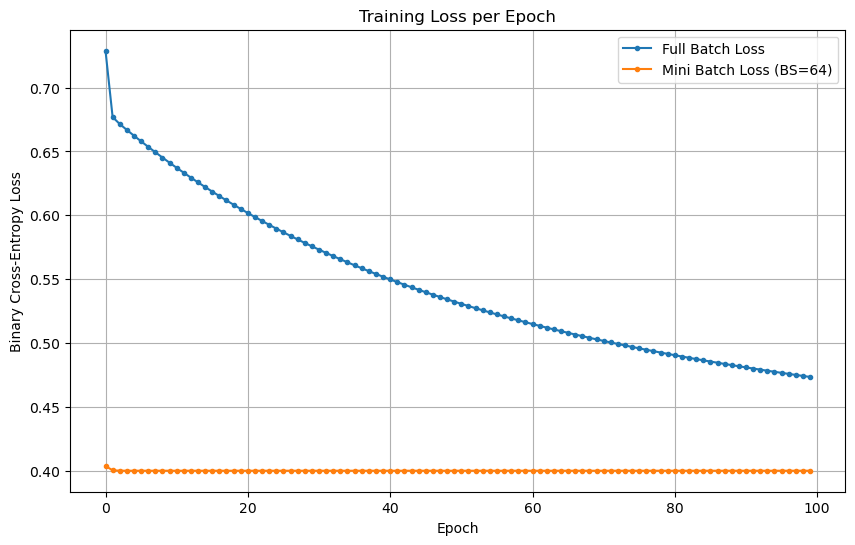

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(losses_full, label='Full Batch Loss', marker='.')
plt.plot(losses_mini, label='Mini Batch Loss (BS=64)', marker='.')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.legend()
plt.grid(True)
plt.show()

## 6. Final Test Set Evaluation (Using Mini-Batch Model)

In [10]:
y_pred_test = model_mini.predict(X_test_norm)
acc_test, cm_test = model_mini.evaluate(y_test, y_pred_test)

print(f"Final Test Set Accuracy: {acc_test:.2f}%")
print("Final Test Set Confusion Matrix [ [TP, FP], [FN, TN] ]:")
print(cm_test)

Final Test Set Accuracy: 80.55%
Final Test Set Confusion Matrix [ [TP, FP], [FN, TN] ]:
[[3315 1305]
 [1029 6351]]
